# Random Acts of Pizza
## Authors: Ben Arnold, Mary Boardman, Zach Merritt, and Kevin Gifford
#### Kaggle Competition Description:
In machine learning, it is often said there are no free lunches. How wrong we were.

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

"I'll write a poem, sing a song, do a dance, play an instrument, whatever! I just want a pizza," says one hopeful poster. What about making an algorithm?

Kaggle is hosting this competition for the machine learning community to use for fun and practice. This data was collected and graciously shared by Althoff et al. (Buy them a pizza -- data collection is a thankless and tedious job!) We encourage participants to explore their accompanying paper and ask that you cite the following reference in any publications that result from your work:

Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014.
_______________________________________________________________________________________________

## Notebook Title: EDA & Model Baseline
#### Purpose: Load the 'Random Acts of Pizza' train and test data. Conduct an exploratory data analysis to gain an understanding of the data. Create a baseline Logisitic Regression model using non-text (numeric) fields only. 

## I. Load Data and Modules, Process Data

### A. Load Data and Modules

In [21]:
#!conda install -c conda-forge wordcloud
#import sys
#!{sys.executable} -m pip install wordcloud

In [126]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from subprocess import check_output
#from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')

In [3]:
#1. Train Data
with open('../data/train.json') as fin:
    trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)
#2. Test Data
with open('../data/test.json') as fin:
    testjson = json.load(fin)
test = pd.io.json.json_normalize(testjson)

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (4040, 32)
Test Shape: (1631, 17)


### B. Identify common columns between test and train

In [6]:
print("Common columns in train and test:")
print(train.columns[train.columns.isin(test.columns)])
print("----")
print("Columns in train but NOT test:")
print(train.columns[~train.columns.isin(test.columns)])

Common columns in train and test:
Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')
----
Columns in train but NOT test:
Index(['number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_number_of_comments_at_retrieval', 'request_text',
       '

As can be seen above, there is a series of columns in the training data only. These columns reflect data about the post (e.g., the #of upvotes) at the time this Reddit data was retrieved. We use certain supervised and unsupversied techniques to derive value from this data (even though that information is not provided on the data set we will be predicting).

### C. Create training data, labels, and special 'in training only' data

In [4]:
train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

### D. Set column types and profile

In [5]:
train_data_master = train_data_master.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_data_master.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_data_master.unix_timestamp_of_request_utc, unit = "s"))

In [6]:
train_data_master.describe()
train_data_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 17 columns):
giver_username_if_known                               4040 non-null object
request_id                                            4040 non-null object
request_text_edit_aware                               4040 non-null object
request_title                                         4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_comments_in_raop_at_request       4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null int64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_number_of_subreddits_at_request             4040 non-null int64
requester_subreddits_at_request                       4040 non-null obj

## II. EDA

### A. Print Example Posts

In [17]:
for a in [False, True]:
    for b in range(2):
        print("requester_received_pizza ==",a)
        print("------")
        i = train[train['requester_received_pizza']==a].index[b]
        print('UID:\t', trainjson[i]['request_id'], '\n')
        print('Title:\t', trainjson[i]['request_title'], '\n')
        print('Text:\t', trainjson[i]['request_text_edit_aware'], '\n')
        print('Tag:\t', trainjson[i]['requester_received_pizza'], end='\n')
        print("______________________________________")
    print("______________________________________")

requester_received_pizza == False
------
UID:	 t3_l25d7 

Title:	 Request Colorado Springs Help Us Please 

Text:	 Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated 

Tag:	 False
______________________________________
requester_received_pizza == False
------
UID:	 t3_rcb83 

Title:	 [Request] California, No cash and I could use some dinner 

Text:	 I spent the last money I had on gas today. Im broke until next Thursday :( 

Tag:	 False
______________________________________
______________________________________
requester_received_pizza == True
------
UID:	 t3_14gmeb 

Title:	 [REQUEST] I'll give a two week xbox live code for a slice of pie! 

Text:	 Feeling under the weather so I called out off work today! I hate requestin

### B. Visualize Dependent Variable: Did the requester recieve a pizza?

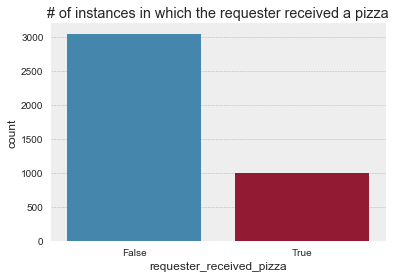

In [18]:
(sns.countplot(x = train_labels_master.requester_received_pizza).
set_title("# of instances in which the requester received a pizza"));

### C. Visualize All Numeric Fields

#### 1. In training and test data

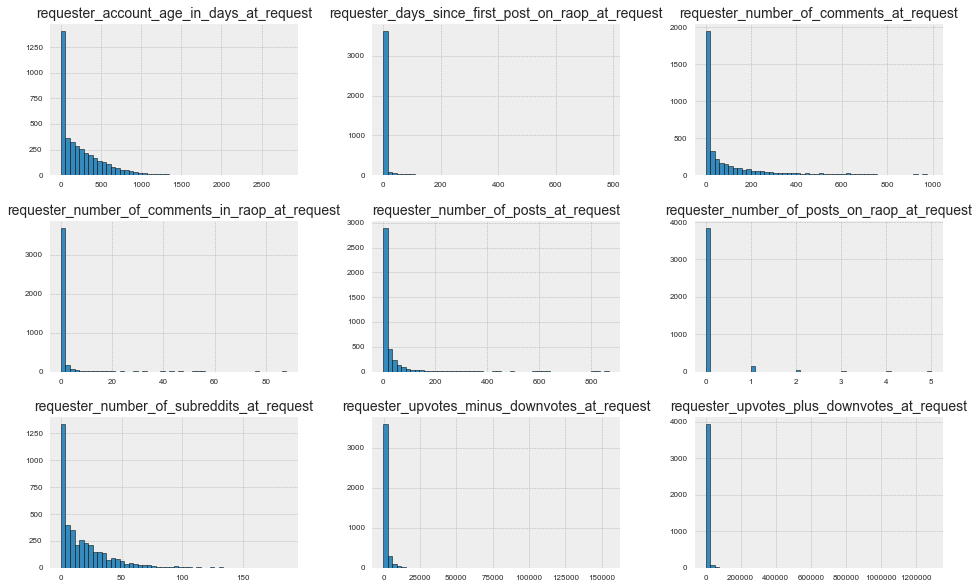

In [201]:
df_num = (train_data_master.select_dtypes(include = ['float64', 'int64']))
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(14) for x in fig.ravel()]
fig;

As seen above...

#### 2. In training data only

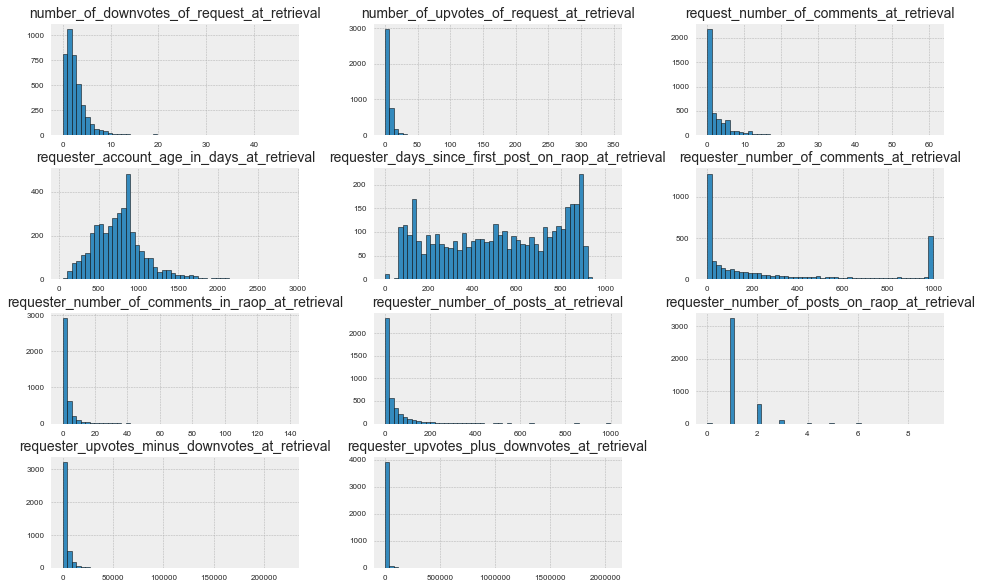

In [20]:
df_num = (train_only_data_master) #all columns are numeric
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(14) for x in fig.ravel()]
fig;

As seen above...

### D. Visualize requests and granted requests over time

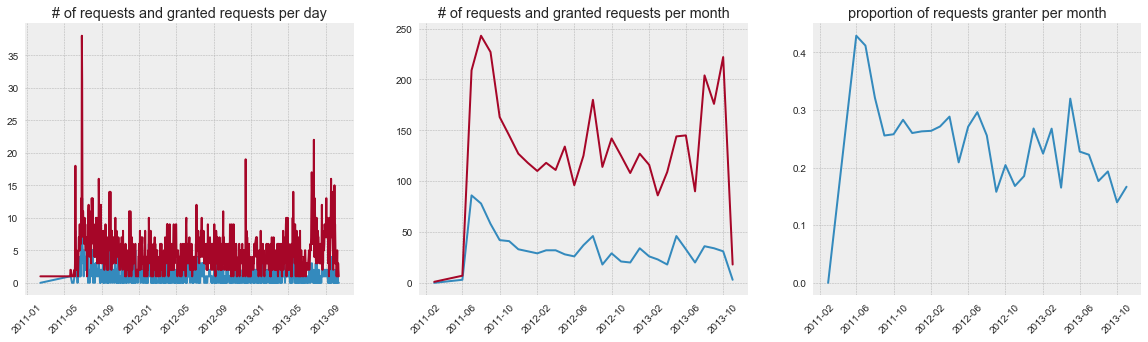

In [136]:
#Data set up
ts = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = train_data_master.unix_timestamp_of_request.dt.date.tolist())
ts = ts.groupby(ts.index).sum()
ts_month = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = (train_data_master.unix_timestamp_of_request.dt.date + pd.offsets.MonthBegin(0)).tolist())
ts_month = ts_month.groupby(ts_month.index).sum()

#Plots
#1. By day
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(ts)
plt.title("# of requests and granted requests per day")
plt.xticks(rotation=45)
#2. By Month
plt.subplot(1,3,2)
plt.plot(ts_month)
plt.title("# of requests and granted requests per month")
plt.xticks(rotation=45)
#3. By Month (prop)
plt.subplot(1,3,3)
plt.plot(ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])['prop_granted'])
plt.title("proportion of requests granter per month")
plt.xticks(rotation=45)
plt.show()

As seen above, there was a spike of requests in the in mid 2011 and in the end of 2013. However, besides those periods, the number of requests has remained relatively stagnant at 100 - 150 per month. 

Additionally, while there is a slight downward trend to the proportion of requests granted, the proportion has also remained relatively stagnant at 15% to 30% of requests being granted per month.

### E. Create Word Clouds of Granted and Ungranted Requests

In [ ]:
granted = train_data_master[train_labels_master['requester_received_pizza']==True]
print(granted.shape)
ungranted = train_data_master[train_labels_master['requester_received_pizza']==False]
print(ungranted.shape)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

In [ ]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(granted['request_text_edit_aware']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ungranted['request_text_edit_aware']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## III. Model 1: Logistic Regression (on common numeric fields only)

In [150]:
def model_report(title, y_test, predictions):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [151]:
#Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
mn_mx_scaler = min_max_scaler.fit_transform(
    train_data_master.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Split train and test data
x_train, x_test, y_train, y_test = train_test_split(
    mn_mx_scaler, 
    train_labels_master.values.ravel(), test_size=0.2, random_state=0)

In [152]:
#Train Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.75      0.99      0.85       602
       True       0.57      0.04      0.07       206

avg / total       0.70      0.75      0.65       808



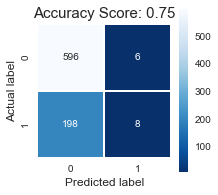

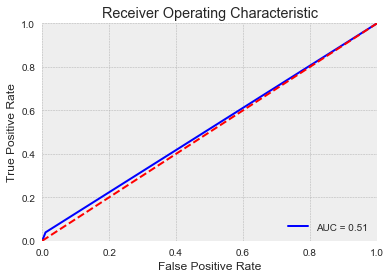

In [153]:
#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

## IV. Model 2: Naive Bayes (Text field only)

In [159]:
#Create Sparse matrix of words
count_vect = CountVectorizer()
#Split train and test data
x_train, x_test, y_train, y_test = train_test_split(
    count_vect.fit_transform(train_data_master['request_text_edit_aware']), 
    train_labels_master.values.ravel(), test_size=0.2, random_state=0)

In [155]:
#Train Model
# all parameters not specified are set to their defaults
nb = MultinomialNB()
nb.fit(x_train, y_train)
predictions = nb.predict(x_test)

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.75      0.92      0.83       602
       True       0.35      0.12      0.18       206

avg / total       0.65      0.72      0.66       808



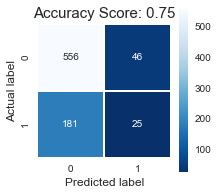

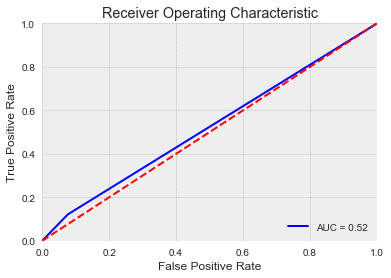

In [156]:
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)